In [1]:
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterSciNotation,LogLocator
%matplotlib inline

In [2]:
data = []
for metric_name in ['DiceAccuracy(threshold=0.5,smoothing=1)','DiceLoss(smoothing=1)']:
    table = []
    for csv_path in pathlib.Path(metric_name).rglob('*.csv'):
        metric_name,model_name,is_pretrained,purpose,csv_name = csv_path.as_posix().split('/')
        df = pd.read_csv(csv_path)
        df['ModelName'] = model_name
        df['IsPretrained'] = is_pretrained
        df['Purpose'] = purpose
        df['TrialNumber'] = csv_name.replace(f'_{purpose}','_').split('_')[-2]
        df = df.rename({'Step':'ImagesCount'},axis='columns')
        df = df.rename({'Value':metric_name},axis='columns')
        df = df.drop('Wall time',axis='columns')
        table.append(df)
    data.append(pd.concat(table).set_index(['ImagesCount','ModelName','IsPretrained','Purpose','TrialNumber']))
data = pd.concat(data,axis='columns')
data = data.reset_index()

images_count_to_epoch = {i:e+1 for e,i in enumerate(sorted(data['ImagesCount'].value_counts(ascending=False)[:30].index))}
epoch_data = data.loc[data['ImagesCount'].isin(images_count_to_epoch.keys())]
epoch_data.insert(1,'Epoch',epoch_data['ImagesCount'].replace(images_count_to_epoch))

epoch_train = epoch_data.query("Purpose=='train'").set_index(['Epoch','ModelName','IsPretrained','TrialNumber']).iloc[:,2:]
epoch_validation = epoch_data.query("Purpose=='validation'").set_index(['Epoch','ModelName','IsPretrained','TrialNumber']).iloc[:,2:]
epoch_validation_wo_arg = epoch_data.query("Purpose=='validation_wo_arg'").set_index(['Epoch','ModelName','IsPretrained','TrialNumber']).iloc[:,2:]

epoch_validation_vs_train = (epoch_validation - epoch_train).reset_index()
epoch_validation_wo_arg_vs_train = (epoch_validation_wo_arg - epoch_train).reset_index()
epoch_validation_wo_arg_vs_validation = (epoch_validation_wo_arg - epoch_validation).reset_index()

In [3]:
pd.options.display.max_rows = 1000
data.groupby(['ModelName','IsPretrained','Purpose','TrialNumber'])['ImagesCount'].count()

ModelName     IsPretrained   Purpose            TrialNumber
AttDs         Pretrained     train              01             780
                                                02             780
                                                03             780
                                                04             780
                                                05             780
                                                06             780
                                                07             780
                                                08             780
                                                09             780
                                                10             780
                             validation         01              30
                                                02              30
                                                03              30
                                                04              30
  

In [22]:
def draw_box_plot(
    data,
    scope,
    metric,
    hue,
    title,
    drop=[],
    figsize=(20,10),
    logy=False,
    font_scale=2,
    whis=[20,80]):
    
    sns.set_theme(style="ticks", palette="pastel",font_scale = font_scale)
    scope = list(scope)
    data = data.copy().loc[data.iloc[:,0].isin(scope)]
    if isinstance(hue,str):
        hue = [hue]
    else:
        assert isinstance(hue,list)

    if hue != ['']:
        data['Model'] = data[hue].apply(lambda x: '_'.join(x),axis=1)
        
        if isinstance(drop,str):
            drop = [drop]
        else:
            assert isinstance(drop,list)

        data = data.loc[~data['Model'].isin(drop)]
        
        hue_order = sorted(data['Model'].unique())
        
        f, ax = plt.subplots(figsize=figsize)
        sns.stripplot(
            x=data.columns[0],
            y=metric,
            hue='Model',
            hue_order = hue_order,
            data=data,
            dodge=True,
            edgecolor='black',
            linewidth=0.5)
        
        box_ax = sns.boxplot(
            x=data.columns[0],
            y=metric,
            hue='Model',
            hue_order = hue_order,
            data=data,
            showfliers=False,
            whis=whis,
            showmeans=True,
            meanline=True,
            meanprops={'color': 'k'},
            )
        
        handles, labels = box_ax.get_legend_handles_labels()
        plt.legend(handles[:len(handles)//2], labels[:len(labels)//2], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    else:
        f, ax = plt.subplots(figsize=figsize)
        sns.stripplot(
            x=data.columns[0],
            y=metric,
            data=data,
            color='b',
            edgecolor='black',
            linewidth=0.5)
        
        box_ax = sns.boxplot(
            x=data.columns[0],
            y=metric,
            data=data,
            color='b',
            showfliers=False,
            whis=whis,
            showmeans=True,
            meanline=True,
            meanprops={'color': 'k'},
            )
        

    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    if logy:
        ax.set_yscale("log")
        ax.yaxis.set_minor_locator(LogLocator(subs=(2,4,6,8)))
        ax.yaxis.set_minor_formatter(LogFormatterSciNotation(labelOnlyBase=False,minor_thresholds=(np.inf, np.inf)))
        ax.yaxis.grid(True,which='minor')
    plt.title(title)
    f.tight_layout()
    plt.show()

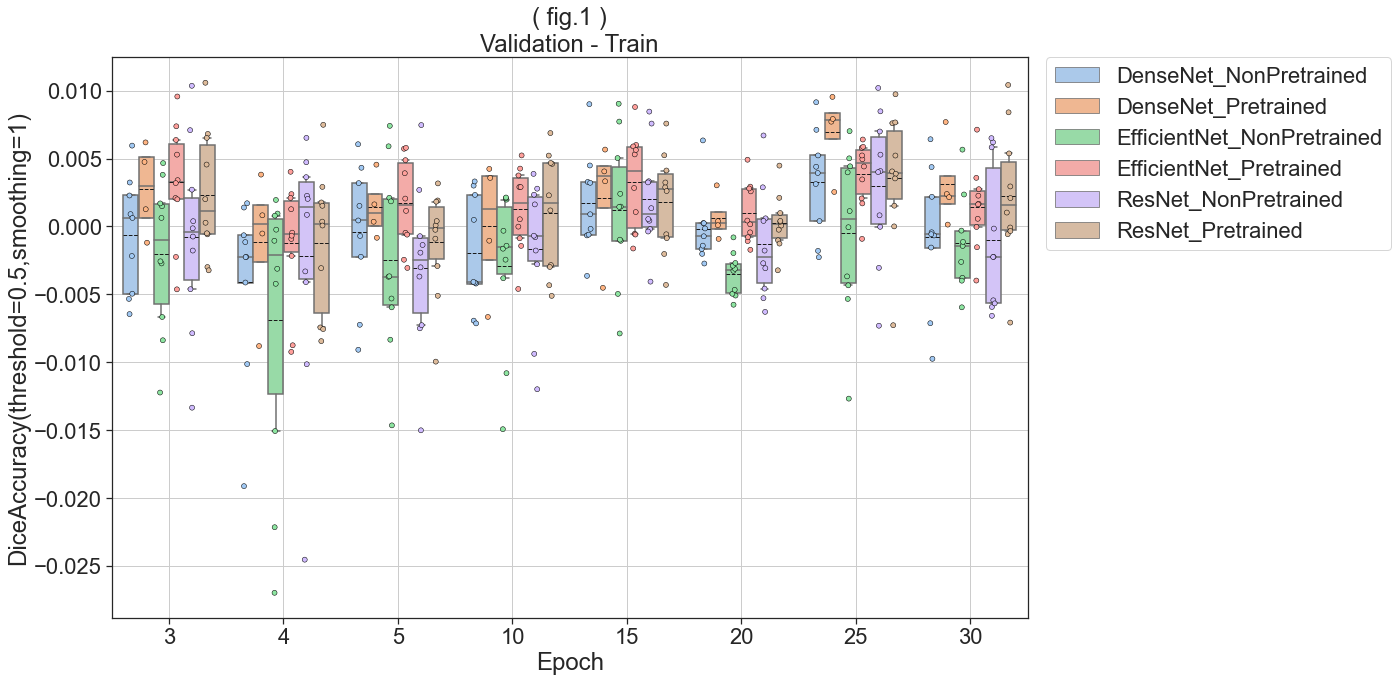

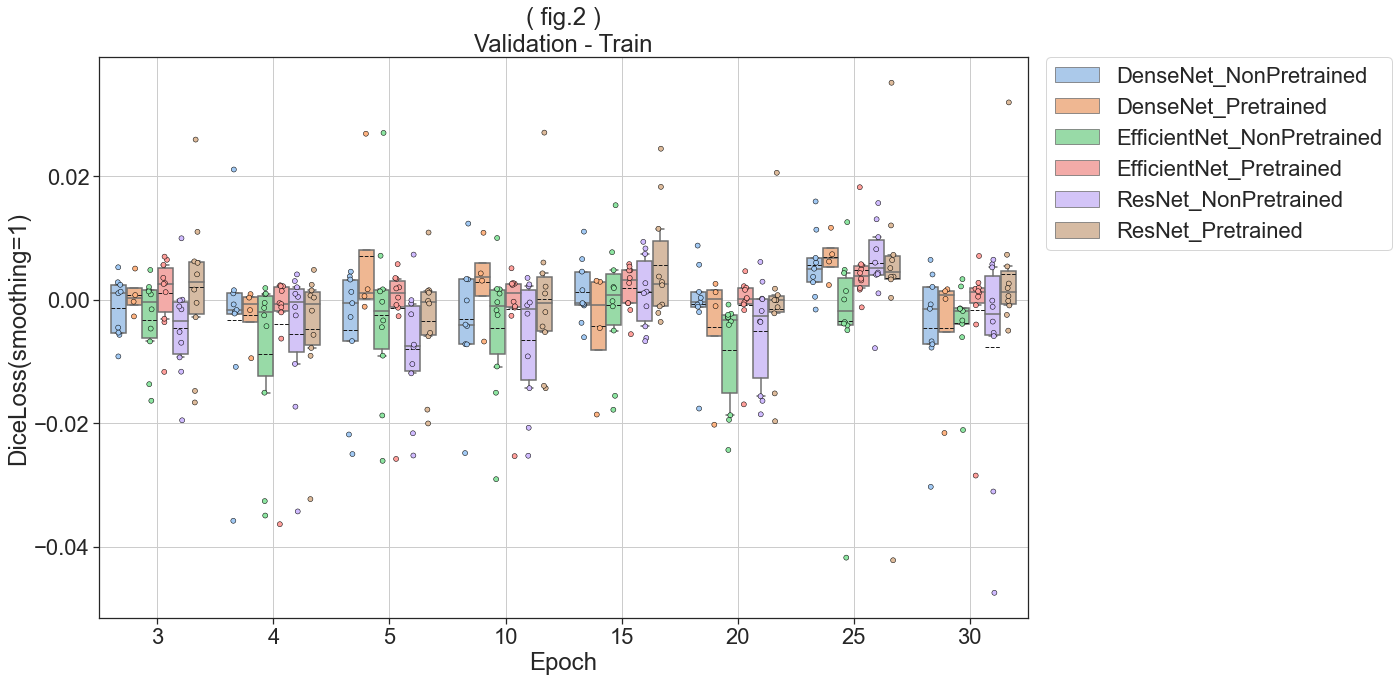

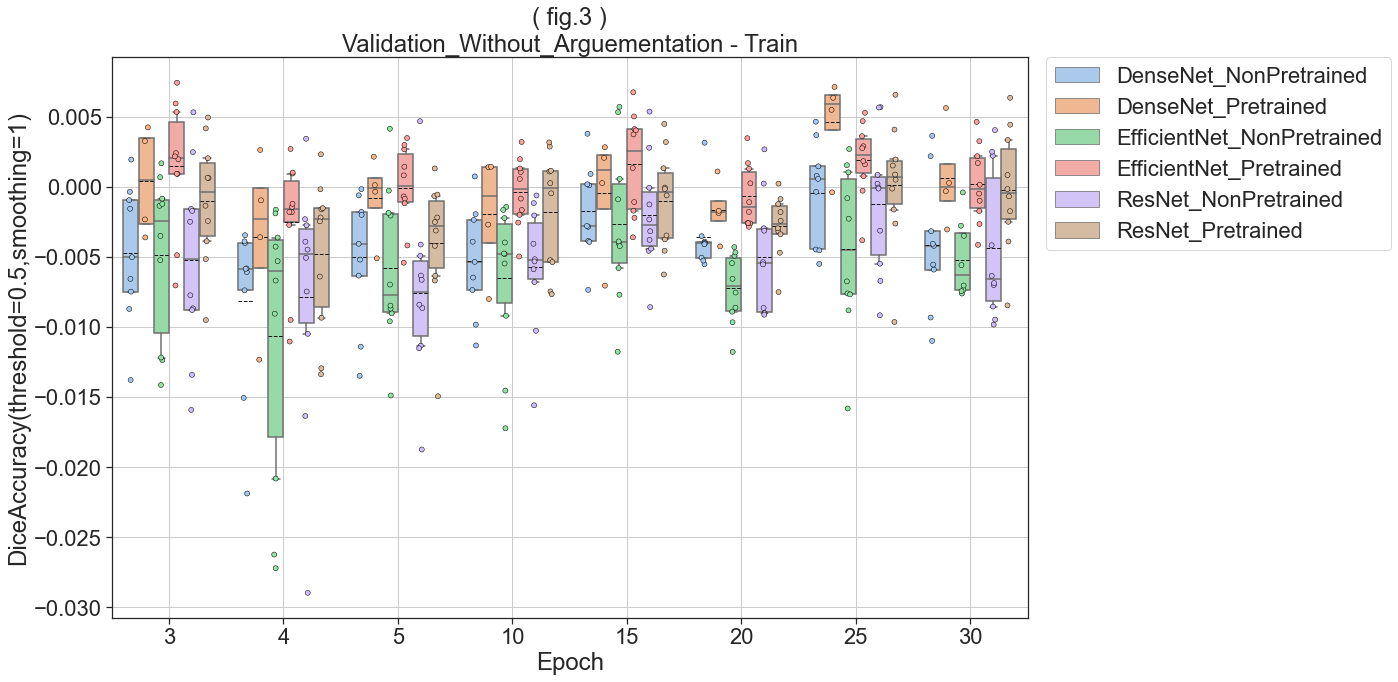

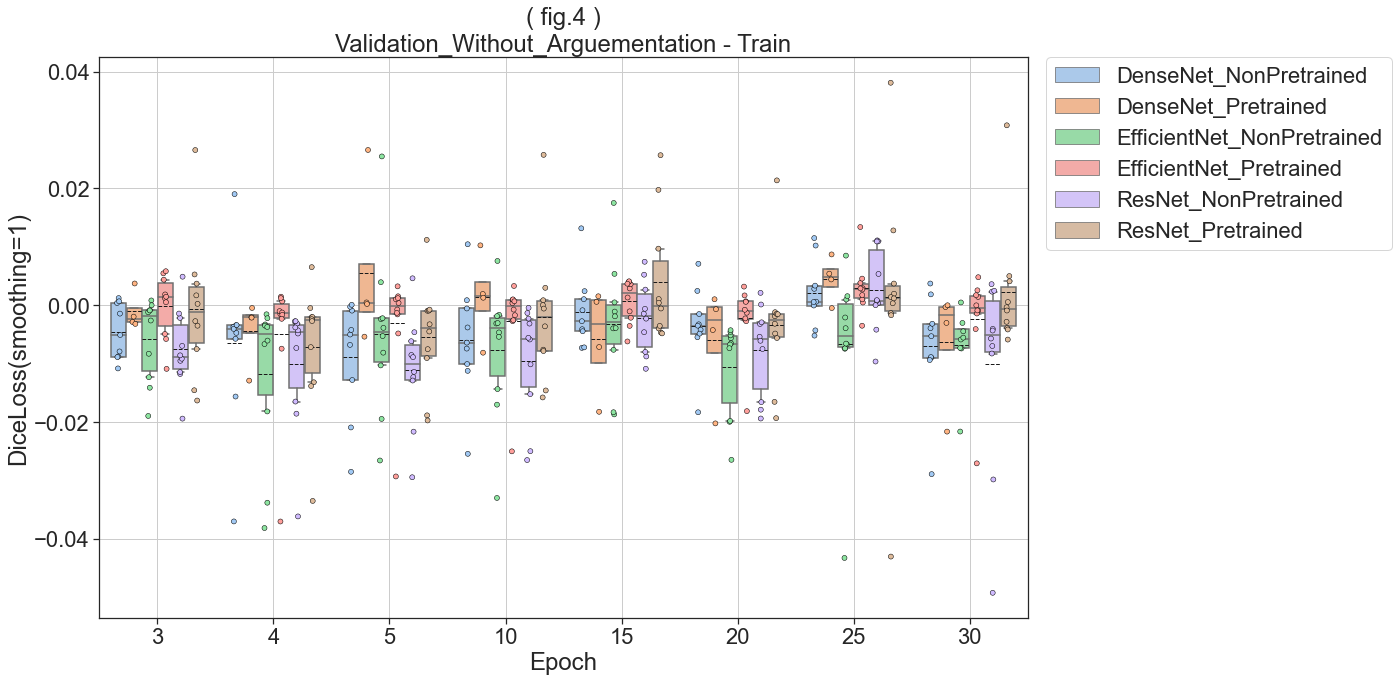


These four figures are used to examinate whether the model is overfitting through out the 30 epochs training process.
DiceLoss and DiceAccuracy are slightly different. DiceLoss is the loss function as well as the target we are minimizing while training, but DiceAccuracy is
just a non-differentiable metric because it replace the predict pixel value higher than threshold with 1 otherwise 0. Despite the replacing step in DiceAccuracy
, DiceLoss and DiceAccuracy share the same process of calculating the loss value.
So we have to make sure the model is not overfitting on either DiceLoss or DiceAccuracy.
As the validation is processed with data arguementation the same as training set and also without data arguementation, we may concern that the model will
perform well on only one of them.
The y axis in the four figures is the difference (shown in the title) of the loss (shown in the y label)
There are 3 common models initialized with and without pretrained weights and ,so there are 6 models

In [23]:
draw_box_plot(
    epoch_validation_vs_train,
    [3,4]+list(range(5,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.1 )\nValidation - Train',
    drop=['AttDs_Pretrained'])
draw_box_plot(
    epoch_validation_vs_train,
    [3,4]+list(range(5,31,5)),
    'DiceLoss(smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.2 )\nValidation - Train',
    drop=['AttDs_Pretrained'])
draw_box_plot(
    epoch_validation_wo_arg_vs_train,
    [3,4]+list(range(5,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.3 )\nValidation_Without_Arguementation - Train',
    drop=['AttDs_Pretrained'])
draw_box_plot(
    epoch_validation_wo_arg_vs_train,
    [3,4]+list(range(5,31,5)),
    'DiceLoss(smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.4 )\nValidation_Without_Arguementation - Train',
    drop=['AttDs_Pretrained'])
print(
'''
These four figures are used to examinate whether the model is overfitting through out the 30 epochs training process.
DiceLoss and DiceAccuracy are slightly different. DiceLoss is the loss function as well as the target we are minimizing while training, but DiceAccuracy is
just a non-differentiable metric because it replace the predict pixel value higher than threshold with 1 otherwise 0. Despite the replacing step in DiceAccuracy
, DiceLoss and DiceAccuracy share the same process of calculating the loss value.
So we have to make sure the model is not overfitting on either DiceLoss or DiceAccuracy.
As the validation is processed with data arguementation the same as training set and also without data arguementation, we may concern that the model will
perform well on only one of them.
The y axis in the four figures is the difference (shown in the title) of the loss (shown in the y label)
There are 3 common models initialized with and without pretrained weights and ,so there are 6 models and each
of them conduct 10 experiments. Each experiment represent one point in the figure and the box shows the statistical description.
In fig.1, fig.2, we can see that the difference is very close to 0, and model performace on valdation set is not inferior to the performace on training set
interms of DiceLoss or DiceAccuracy after 30 epochs of training. (If overfitted, the difference value should be greater than 0)
And similiar result can also be find in the validation set without arguementation in fig.3, fig.4.
So, during the 30 epochs of training, the model is not goinig to overfit on either DiceLoss or DiceAccuracy and with or without data arguementation.
''')


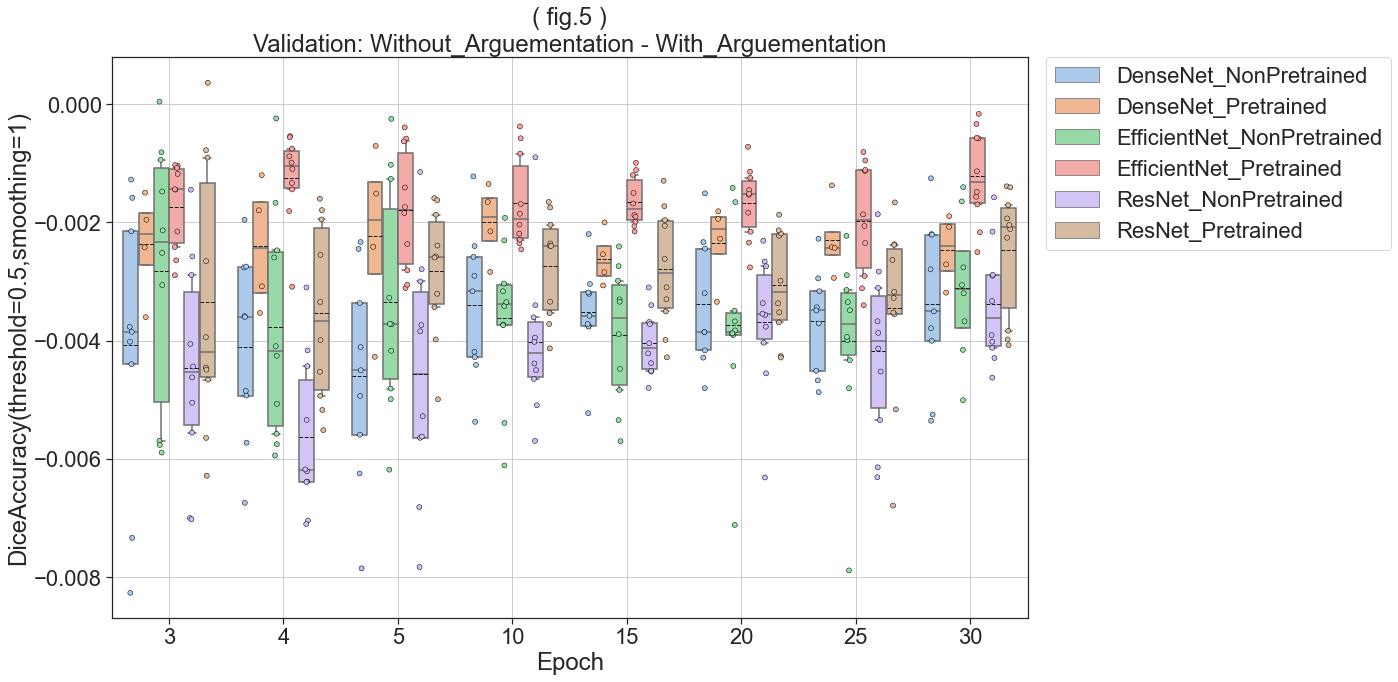

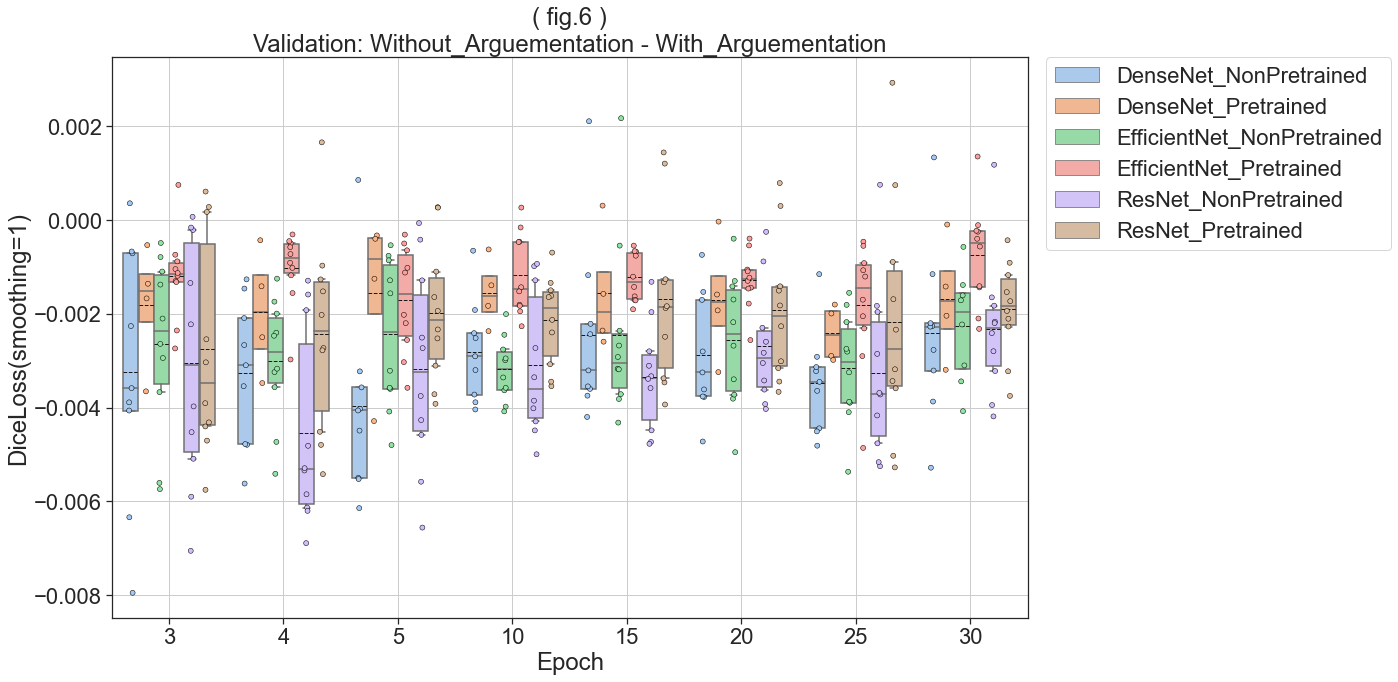


Although we know there is no overfitting, we still need to find out the performace affected by data arguementation becauce we are more interested in validation
set without arguenentation as it is more reasonable when facing the real world.
As we can see , generally speaking, difference value of DiceLoss and DiceAccuracy are negative meaning that model performs better without data arguementation
and has lower loss.



In [24]:
draw_box_plot(
    epoch_validation_wo_arg_vs_validation,
    [3,4]+list(range(5,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.5 )\nValidation: Without_Arguementation - With_Arguementation',
    drop=['AttDs_Pretrained'])
draw_box_plot(
    epoch_validation_wo_arg_vs_validation,
    [3,4]+list(range(5,31,5)),
    'DiceLoss(smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.6 )\nValidation: Without_Arguementation - With_Arguementation',
    drop=['AttDs_Pretrained'])
print(
'''
Although we know there is no overfitting, we still need to find out the performace affected by data arguementation becauce we are more interested in validation
set without arguenentation as it is more reasonable when facing the real world.
As we can see , generally speaking, difference value of DiceLoss and DiceAccuracy are negative meaning that model performs better without data arguementation
and has lower loss.
''')

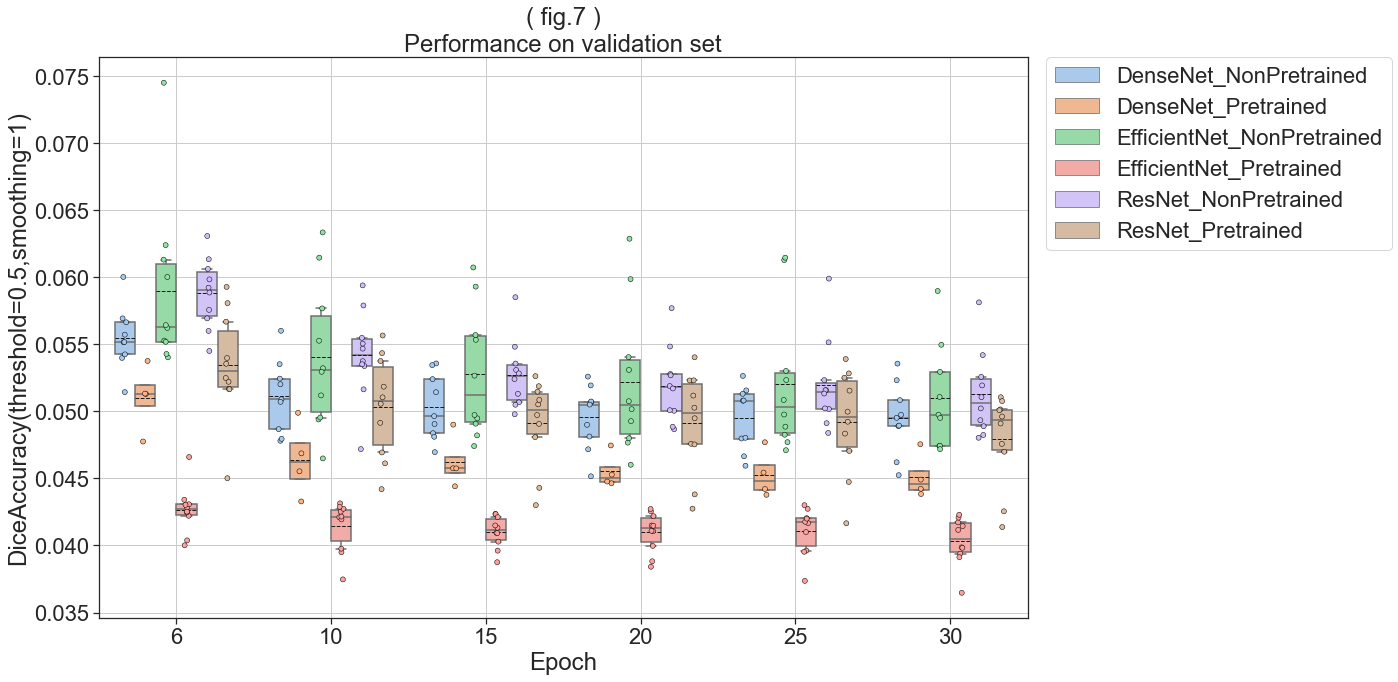

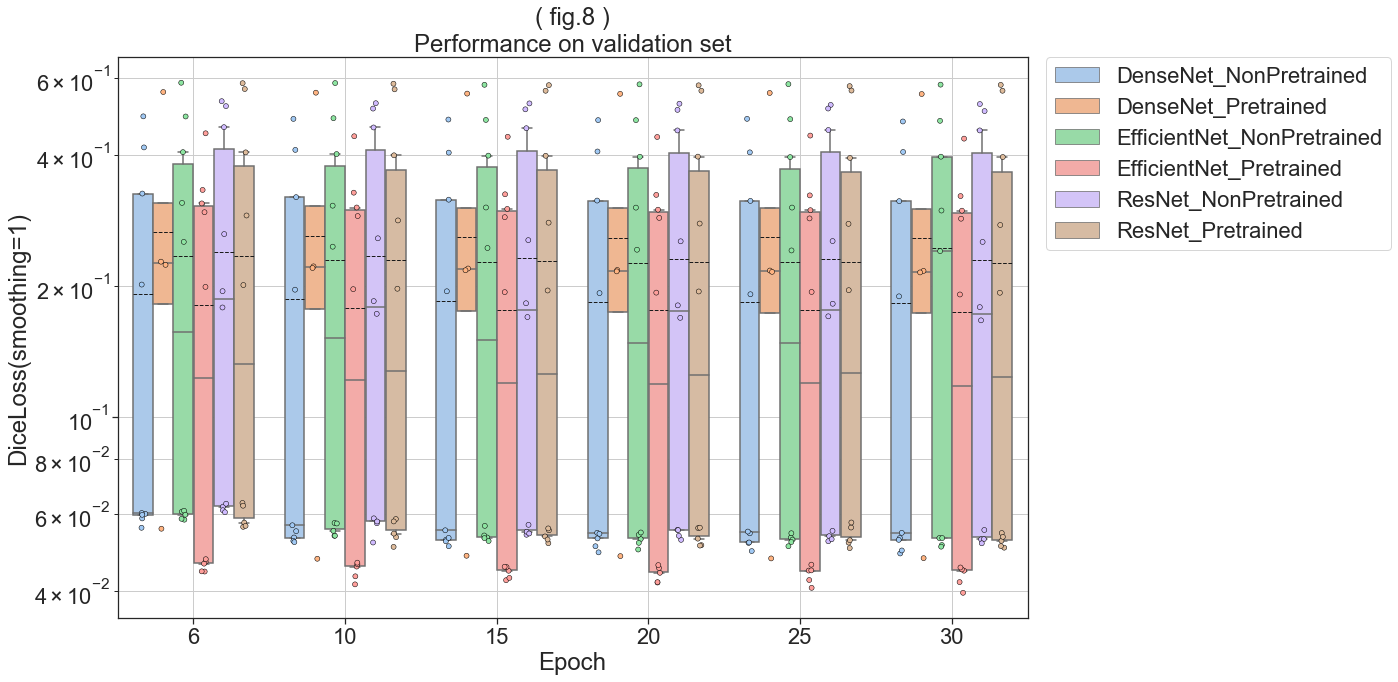

In [25]:
draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation'"),
    [6]+list(range(10,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.7 )\nPerformance on validation set',
    drop=['AttDs_Pretrained'])

draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation'"),
    [6]+list(range(10,31,5)),
    'DiceLoss(smoothing=1)',
    ['ModelName','IsPretrained'],
    '( fig.8 )\nPerformance on validation set',
    drop=['AttDs_Pretrained'],
    logy=True)

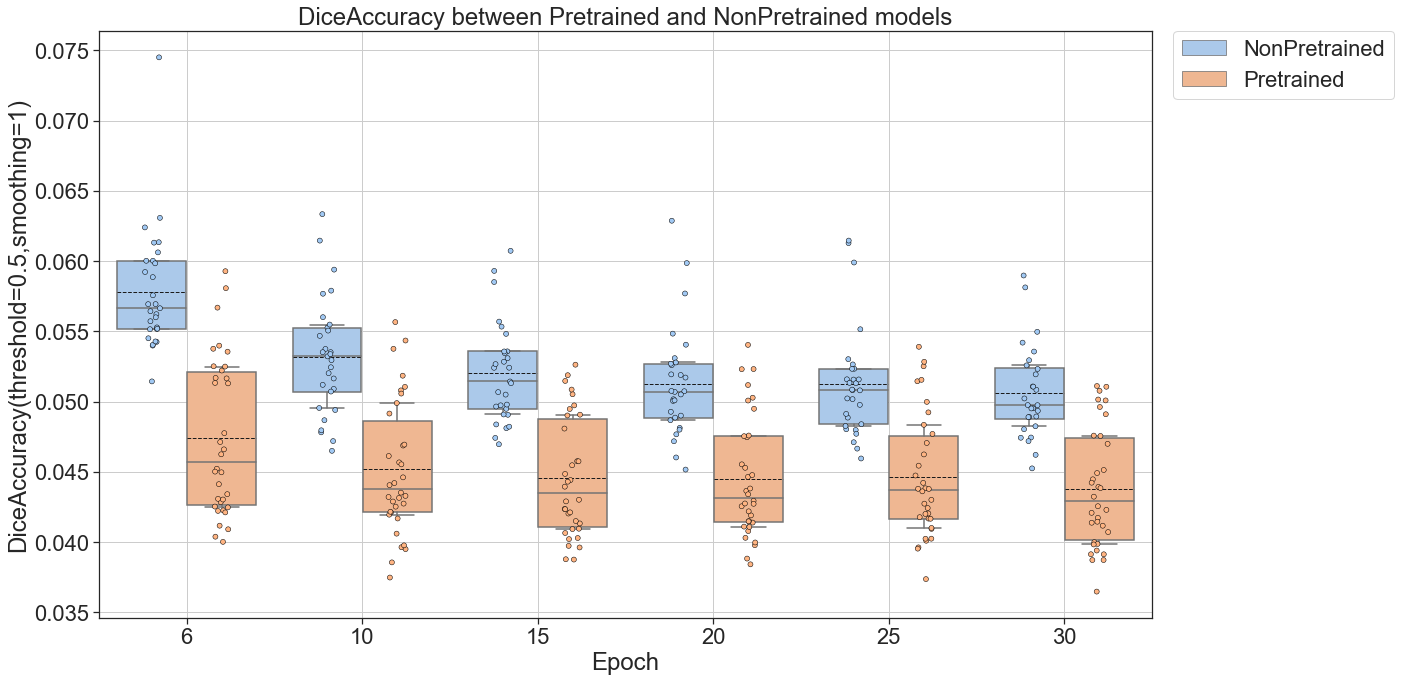

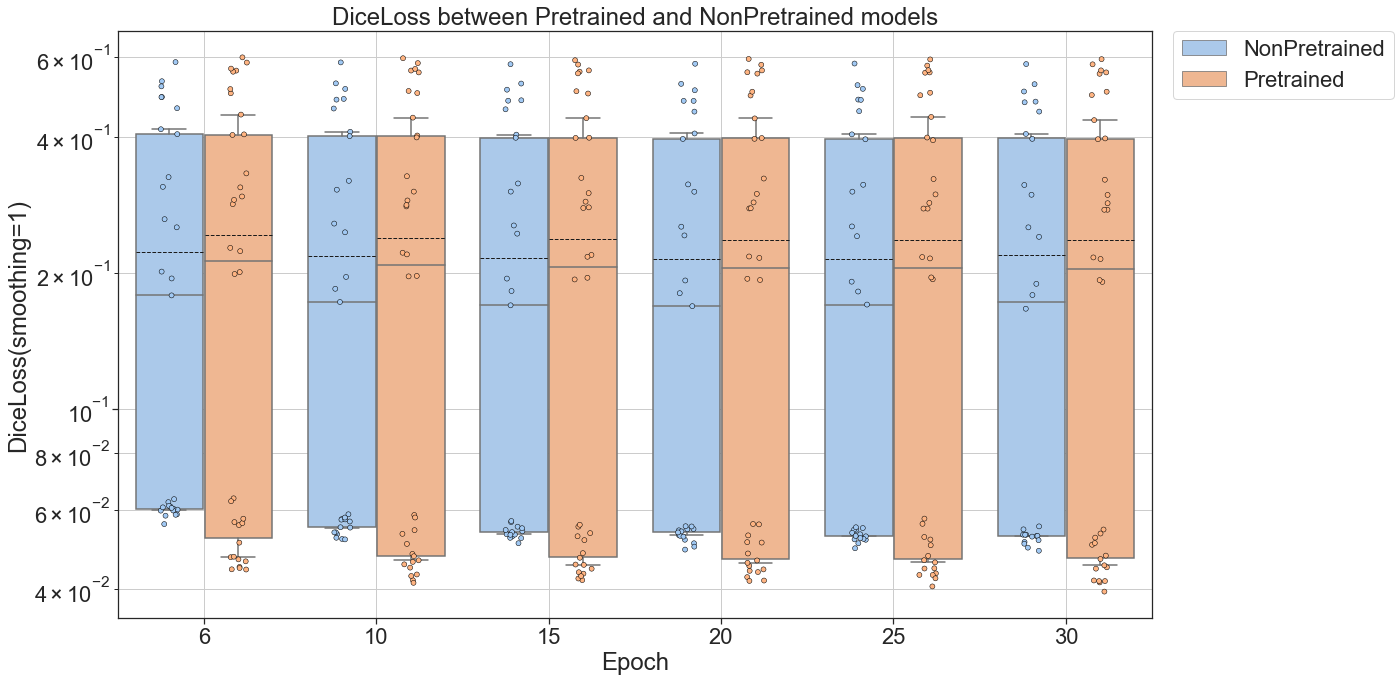

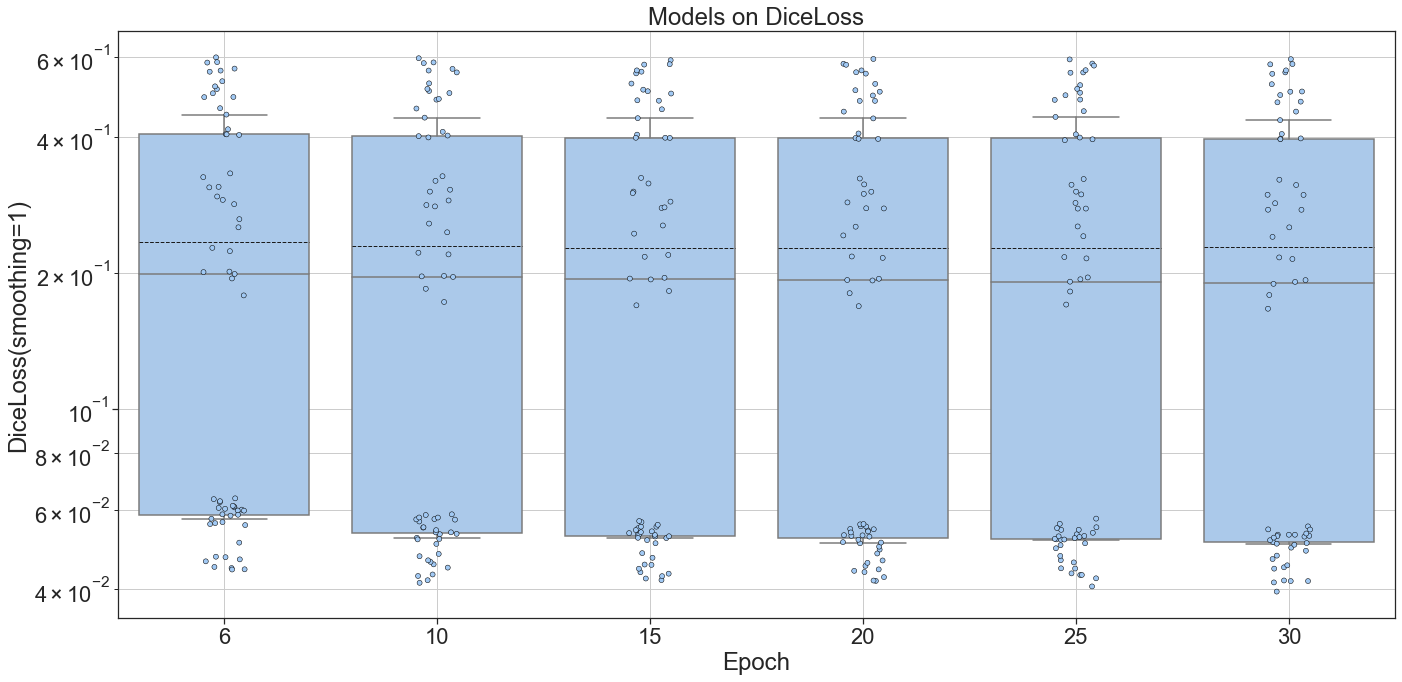

In [26]:
draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation'"),
    [6]+list(range(10,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['IsPretrained'],
    'DiceAccuracy between Pretrained and NonPretrained models',
    drop=['AttDs_Pretrained'])

draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation'"),
    [6]+list(range(10,31,5)),
    'DiceLoss(smoothing=1)',
    ['IsPretrained'],
    'DiceLoss between Pretrained and NonPretrained models',
    drop=['AttDs_Pretrained'],
    logy=True)

draw_box_plot(
    epoch_data.iloc[:,1:].query("Purpose=='validation'"),
    [6]+list(range(10,31,5)),
    'DiceLoss(smoothing=1)',
    [''],
    'Models on DiceLoss',
    drop=['AttDs_Pretrained'],
    logy=True)

In [11]:
metrics_difference_epoch_data = epoch_data.copy()
metrics_difference_epoch_data['DiceLoss - DiceAccuracy'] = epoch_data['DiceLoss(smoothing=1)']-epoch_data['DiceAccuracy(threshold=0.5,smoothing=1)']

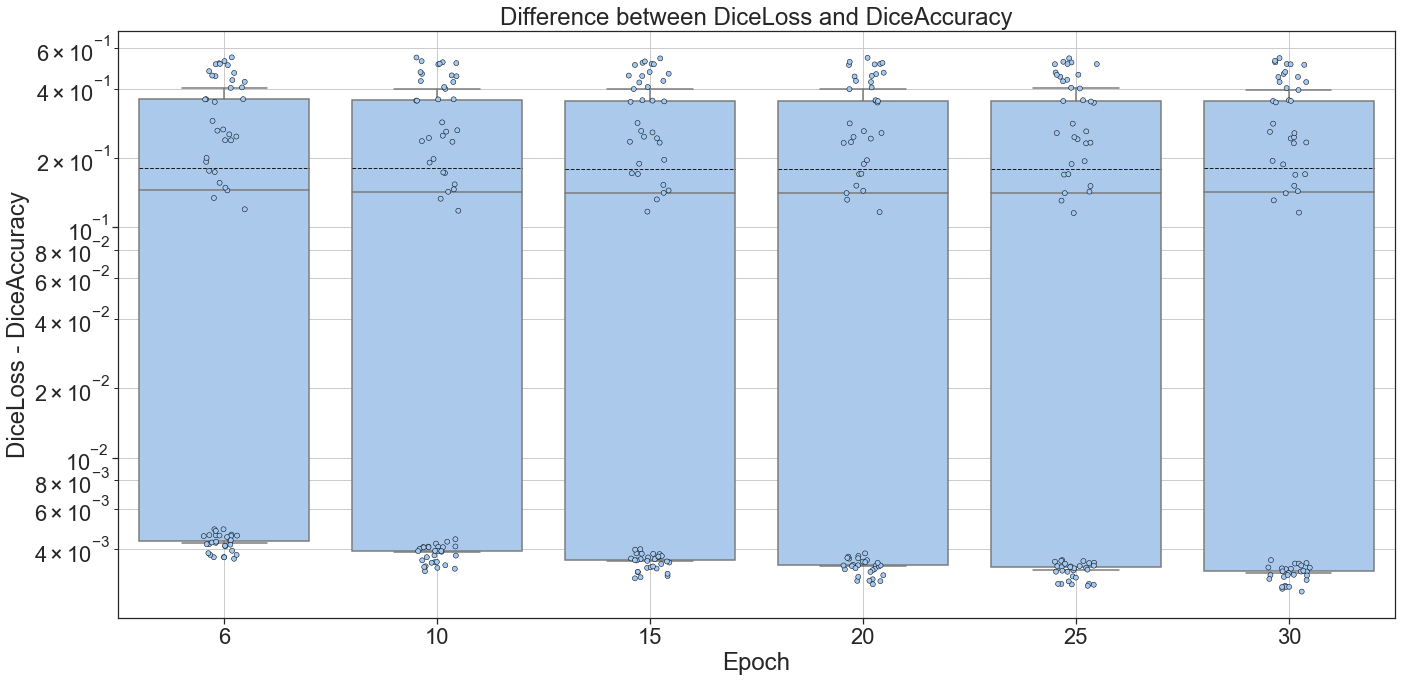

In [27]:
draw_box_plot(
    metrics_difference_epoch_data.iloc[:,1:].query("Purpose=='validation'"),
    [6]+list(range(10,31,5)),
    'DiceLoss - DiceAccuracy',
    [''],
    'Difference between DiceLoss and DiceAccuracy',
    drop=['AttDs_Pretrained'],
    logy=True)

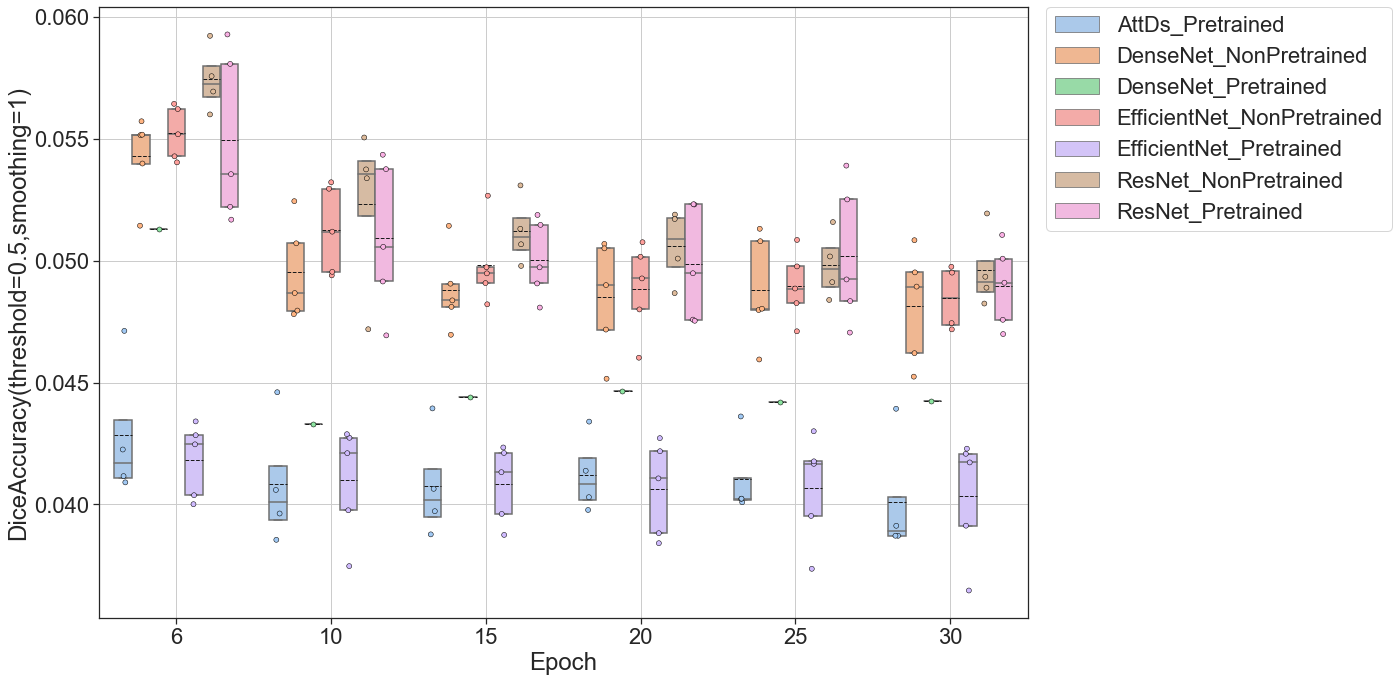

In [28]:
draw_box_plot(
    epoch_data.loc[metrics_difference_epoch_data['DiceLoss - DiceAccuracy'] < 1e-2].iloc[:,1:].query("Purpose=='validation'"),
    [6]+list(range(10,31,5)),
    'DiceAccuracy(threshold=0.5,smoothing=1)',
    ['ModelName','IsPretrained'],
    '')